In [9]:
import os
import cv2
import time
import random
import math
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch import optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from albumentations import (Resize, RandomCrop,VerticalFlip, HorizontalFlip, Normalize, Compose, CLAHE, Rotate)
from albumentations.pytorch import ToTensor
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import segmentation_models_pytorch as smp
import imageio

In [10]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
os.environ["CUDA_VISIBLE_DEVICE"] = '0'
print(torch.cuda.get_device_name(0))

GeForce RTX 2070


In [25]:
def get_transforms(phase, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)): 
    list_transforms = [] 
    if phase == "train": 
        list_transforms.extend( 
            [ 
                HorizontalFlip(), 
                VerticalFlip(),
                Rotate(),
            ] ) 
    list_transforms.extend( [Resize(480, 480, interpolation=Image.BILINEAR),CLAHE(), Normalize(mean=mean, std=std, p=1), ToTensor(),] ) 
    list_trfms = Compose(list_transforms) 
    return list_trfms

In [26]:
def readImg(im_fn):
    im = cv2.imread(im_fn)
    if im is None :
        tmp = imageio.mimread(im_fn)
        if tmp is not None:
            im = np.array(tmp)
            im = im.transpose(1,2,0)
        else:
            image = Image.open(im_fn)
            im = np.asarray(image)
    else:
        im = cv2.cvtColor(np.asarray(im), cv2.COLOR_BGR2RGB)
    
    return im

In [27]:
class RetinalDataset(Dataset):
    def __init__(self, name, img_root, gt_root, phase):
        super().__init__()
        self.inputs = []
        self.gts = []
        self.transform = get_transforms(phase)
        
        for root in img_root:
            file_list = os.getcwd() + root
            list_image = os.listdir(file_list)
            list_image.sort()

            for i, image_path in enumerate(list_image):
                img = os.path.join(file_list,list_image[i])
                self.inputs.append(img)
                
        for root in gt_root:
            file_list = os.getcwd() + root
            list_image = os.listdir(file_list)
            list_image.sort()

            for i, image_path in enumerate(list_image):
                img = os.path.join(file_list,list_image[i])
                self.gts.append(img)

        print('Load %s: %d samples for %s'%(name, len(self.inputs),phase))


    def __len__(self):
        return len(self.inputs)


    def __getitem__(self, index):
        
        image = readImg(self.inputs[index])
        mask = readImg(self.gts[index])
        if mask.shape[2] == 3:
            mask = mask[:,:,0]
            
        augmented = self.transform(image=image, mask=mask.squeeze()) 
        return augmented["image"], augmented["mask"]


In [28]:
# DRIVE 数据集
dr_train_loader = RetinalDataset('DRIVE',['\\data\\DRIVE\\train\\images'],
                           ['\\data\\DRIVE\\train\\1st_manual'], 'train')
dr_test_loader = RetinalDataset('DRIVE',['\\data\\DRIVE\\test\\images'],
                           ['\\data\\DRIVE\\test\\1st_manual'], 'test')

# STARE 数据集
st_train_loader = RetinalDataset('STARE',['\\data\\STARE\\train\\image'],
                           ['\\data\\STARE\\train\\labels-ah'], 'train')
st_test_loader = RetinalDataset('STARE',['\\data\\STARE\\test\\image'],
                           ['\\data\\STARE\\test\\labels-ah'], 'test')

# CHASEDB1 数据集
st_train_loader = RetinalDataset('CHASEDB1',['\\data\\CHASEDB1\\train\\image'],
                           ['\\data\\CHASEDB1\\train\\1st'], 'train')
st_test_loader = RetinalDataset('CHASEDB1',['\\data\\CHASEDB1\\test\\image'],
                           ['\\data\\CHASEDB1\\test\\1st'], 'test')

# HRF 数据集
hr_train_loader = RetinalDataset('HRF',['\\data\\HRF\\train\\images'],
                           ['\\data\\HRF\\train\\manual1'], 'train')
hr_test_loader = RetinalDataset('HRF',['\\data\\HRF\\test\\images'],
                           ['\\data\\HRF\\test\\manual1'], 'test')

# 混合训练集
all_train_loader = RetinalDataset('all',['\\data\\DRIVE\\train\\images','\\data\\STARE\\train\\image',
                                        '\\data\\CHASEDB1\\train\\image','\\data\\HRF\\train\\images'],
                                 ['\\data\\DRIVE\\train\\1st_manual','\\data\\STARE\\train\\labels-ah',
                                 '\\data\\CHASEDB1\\train\\1st','\\data\\HRF\\train\\manual1'],'train')

all_test_loader = RetinalDataset('all',['\\data\\DRIVE\\test\\images','\\data\\STARE\\test\\image',
                                        '\\data\\CHASEDB1\\test\\image','\\data\\HRF\\test\\images'],
                                 ['\\data\\DRIVE\\test\\1st_manual','\\data\\STARE\\test\\labels-ah',
                                 '\\data\\CHASEDB1\\test\\1st','\\data\\HRF\\test\\manual1'],'test')

Load DRIVE: 20 samples for train
Load DRIVE: 20 samples for test
Load STARE: 10 samples for train
Load STARE: 10 samples for test
Load CHASEDB1: 14 samples for train
Load CHASEDB1: 14 samples for test
Load HRF: 21 samples for train
Load HRF: 24 samples for test
Load all: 65 samples for train
Load all: 68 samples for test


In [29]:
'''
ckpt_path = "./model.pth"
device = torch.device("cuda")
model = smp.Unet("resnet50", encoder_weights=None, classes=1, activation=None)
model.to(device)
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
'''
net = smp.Unet('resnet18', classes=1, activation=None, encoder_weights='imagenet')
net.cuda()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [30]:
class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

In [31]:
batch_size = 8
epochs = 500
lr = 0.001
batch_iter = math.ceil(len(all_train_loader) / batch_size)

net_name = 'Unet-Resnet18'
loss_fuc = 'BCEL'

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=4, verbose=True)

dataset = "all"
trainloader = DataLoader(all_train_loader, batch_size=batch_size, shuffle=True, pin_memory=True)
testloader = DataLoader(all_test_loader, batch_size=1, shuffle=False, pin_memory=True)

In [32]:
result_path = 'results'
if not os.path.exists(result_path):
    os.makedirs(result_path)
weights_path =  "weights"
if not os.path.exists(weights_path):
    os.makedirs(weights_path)

f_loss = open(os.path.join(result_path, "log_%s_%s_%s.txt"%(dataset,loss_fuc,net_name)),'w')
f_loss.write('Dataset : %s\n'%dataset)
f_loss.write('Loss : %s\n'%loss_fuc)
f_loss.write('Net : %s\n'%net_name)
f_loss.write('Learning rate: %05f\n'%lr)
f_loss.write('batch-size: %s\n'%batch_size)
f_loss.close()

In [33]:
image_path = os.path.join(result_path,dataset)
if not os.path.exists(image_path):
    os.makedirs(image_path)

In [34]:
def train(e):
    print('start train epoch: %d'%e)
    net.train()
    
    loss_plot = []
    
    for i, (x,y) in enumerate(trainloader):
        optimizer.zero_grad()
        x = x.cuda(async=True)
        y = y.cuda(async=True)
        
        x = net(x)
        
        loss = criterion(x.squeeze(), y.squeeze())
        #loss = loss + criterion[1](x.squeeze(), y.squeeze())
        print('Epoch:%d  Batch:%d/%d  loss:%08f'%(e, i+1, batch_iter, loss.data))
        
        loss_plot.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_plot

In [35]:
def test():
    net.eval()
    acc = torch.tensor(0)
    tpr = torch.tensor(0)
    fpr = torch.tensor(0)
    sn = torch.tensor(0)
    sp = torch.tensor(0)
    
    
    for i, (x,y) in enumerate(testloader):
        optimizer.zero_grad()
        x = x.cuda(async=True)
        y = y.cuda(async=True)
        x = net(x)
        
        x = torch.sigmoid(x).squeeze()
        y = y.squeeze().int().long()
        
        x = torch.where(x > 0.5, torch.tensor(1).cuda(), torch.tensor(0).cuda())
        
        temp = x + torch.tensor(2).cuda().long() * y
        tp = torch.sum(torch.where(temp == 3, torch.tensor(1).cuda(),torch.tensor(0).cuda())).float()
        fp = torch.sum(torch.where(temp == 1, torch.tensor(1).cuda(),torch.tensor(0).cuda())).float()
        tn = torch.sum(torch.where(temp == 0, torch.tensor(1).cuda(),torch.tensor(0).cuda())).float()
        fn = torch.sum(torch.where(temp == 2, torch.tensor(1).cuda(),torch.tensor(0).cuda())).float()
        
        acc = acc + (tp + tn) / (tp + fp + tn + fn)
        tpr = tpr + tp / (tp + fn)
        fpr = fpr + fp / (tn + fp)
        sn = sn + tn / (tn + fp)
        sp = sp + tp / (tp + fn)
        
    acc = (acc / len(testloader)).cpu().numpy()
    tpr = (tpr / len(testloader)).cpu().numpy()
    fpr = (fpr / len(testloader)).cpu().numpy()
    sn = (sn / len(testloader)).cpu().numpy()
    sp = (sp / len(testloader)).cpu().numpy()
    
    print('ACC:',acc)
    print('TPR:',tpr)
    print('FPR:',fpr)
    print('SN:',sn)
    print('SP:',sp)
    
    f_log = open(os.path.join(result_path, "log_%s_%s_%s.txt"%(dataset,loss_fuc,net_name)),'a')
    f_log.write('Epoch:%d  acc:%08f\n'%(e, acc))
    f_log.write('Epoch:%d  TPR:%08f\n'%(e, tpr))
    f_log.write('Epoch:%d  FPR:%08f\n'%(e, fpr))
    f_log.write('Epoch:%d  SN:%08f\n'%(e, sn))
    f_log.write('Epoch:%d  SP:%08f\n'%(e, sp))
    f_log.close()     
    
    return acc

In [37]:
best_acc = 0
loss_plot = [0]
for e in range(1, epochs + 1):
    loss_plot = loss_plot + train(e)
    if e % 10 == 0:
        acc = test()
        if acc > best_acc:
            if best_acc != 0:
                os.remove(os.path.join(weights_path,
                         'net_%s_%s_%s_%f.pth'%(dataset,loss_fuc,net_name,best_acc)))
            torch.save(net.state_dict(),os.path.join(weights_path,
                         'net_%s_%s_%s_%f.pth'%(dataset,loss_fuc,net_name,acc)))  
            best_acc = acc

start train epoch: 1
Epoch:1  Batch:1/9  loss:0.592653
Epoch:1  Batch:2/9  loss:0.522623
Epoch:1  Batch:3/9  loss:0.471198
Epoch:1  Batch:4/9  loss:0.435442
Epoch:1  Batch:5/9  loss:0.409874
Epoch:1  Batch:6/9  loss:0.378652
Epoch:1  Batch:7/9  loss:0.354120
Epoch:1  Batch:8/9  loss:0.337933
Epoch:1  Batch:9/9  loss:0.327909
start train epoch: 2
Epoch:2  Batch:1/9  loss:0.302346
Epoch:2  Batch:2/9  loss:0.295034
Epoch:2  Batch:3/9  loss:0.284414
Epoch:2  Batch:4/9  loss:0.264138
Epoch:2  Batch:5/9  loss:0.253476
Epoch:2  Batch:6/9  loss:0.246476
Epoch:2  Batch:7/9  loss:0.231249
Epoch:2  Batch:8/9  loss:0.233345
Epoch:2  Batch:9/9  loss:0.215323
start train epoch: 3
Epoch:3  Batch:1/9  loss:0.215926
Epoch:3  Batch:2/9  loss:0.208326
Epoch:3  Batch:3/9  loss:0.204228
Epoch:3  Batch:4/9  loss:0.194243
Epoch:3  Batch:5/9  loss:0.186558
Epoch:3  Batch:6/9  loss:0.194066
Epoch:3  Batch:7/9  loss:0.184495
Epoch:3  Batch:8/9  loss:0.186846
Epoch:3  Batch:9/9  loss:0.164881
start train epoch: 

Epoch:25  Batch:2/9  loss:0.086914
Epoch:25  Batch:3/9  loss:0.087247
Epoch:25  Batch:4/9  loss:0.120450
Epoch:25  Batch:5/9  loss:0.087060
Epoch:25  Batch:6/9  loss:0.098557
Epoch:25  Batch:7/9  loss:0.093593
Epoch:25  Batch:8/9  loss:0.093108
Epoch:25  Batch:9/9  loss:0.071359
start train epoch: 26
Epoch:26  Batch:1/9  loss:0.103343
Epoch:26  Batch:2/9  loss:0.105890
Epoch:26  Batch:3/9  loss:0.091444
Epoch:26  Batch:4/9  loss:0.092861
Epoch:26  Batch:5/9  loss:0.097377
Epoch:26  Batch:6/9  loss:0.096719
Epoch:26  Batch:7/9  loss:0.097736
Epoch:26  Batch:8/9  loss:0.088680
Epoch:26  Batch:9/9  loss:0.095924
start train epoch: 27
Epoch:27  Batch:1/9  loss:0.099298
Epoch:27  Batch:2/9  loss:0.089428
Epoch:27  Batch:3/9  loss:0.093813
Epoch:27  Batch:4/9  loss:0.091254
Epoch:27  Batch:5/9  loss:0.099557
Epoch:27  Batch:6/9  loss:0.102138
Epoch:27  Batch:7/9  loss:0.094004
Epoch:27  Batch:8/9  loss:0.098656
Epoch:27  Batch:9/9  loss:0.121087
start train epoch: 28
Epoch:28  Batch:1/9  los

Epoch:49  Batch:1/9  loss:0.089961
Epoch:49  Batch:2/9  loss:0.099994
Epoch:49  Batch:3/9  loss:0.090323
Epoch:49  Batch:4/9  loss:0.086669
Epoch:49  Batch:5/9  loss:0.082062
Epoch:49  Batch:6/9  loss:0.092239
Epoch:49  Batch:7/9  loss:0.087712
Epoch:49  Batch:8/9  loss:0.093247
Epoch:49  Batch:9/9  loss:0.062436
start train epoch: 50
Epoch:50  Batch:1/9  loss:0.083157
Epoch:50  Batch:2/9  loss:0.091892
Epoch:50  Batch:3/9  loss:0.079403
Epoch:50  Batch:4/9  loss:0.091498
Epoch:50  Batch:5/9  loss:0.095676
Epoch:50  Batch:6/9  loss:0.090242
Epoch:50  Batch:7/9  loss:0.080403
Epoch:50  Batch:8/9  loss:0.083455
Epoch:50  Batch:9/9  loss:0.081352
ACC: 0.96699244
TPR: 0.7662155
FPR: 0.01598511
SN: 0.984015
SP: 0.7662155
start train epoch: 51
Epoch:51  Batch:1/9  loss:0.095823
Epoch:51  Batch:2/9  loss:0.082443
Epoch:51  Batch:3/9  loss:0.084181
Epoch:51  Batch:4/9  loss:0.091143
Epoch:51  Batch:5/9  loss:0.096815
Epoch:51  Batch:6/9  loss:0.091423
Epoch:51  Batch:7/9  loss:0.085695
Epoch:5

Epoch:72  Batch:8/9  loss:0.087118
Epoch:72  Batch:9/9  loss:0.078549
start train epoch: 73
Epoch:73  Batch:1/9  loss:0.087987
Epoch:73  Batch:2/9  loss:0.084855
Epoch:73  Batch:3/9  loss:0.079888
Epoch:73  Batch:4/9  loss:0.084000
Epoch:73  Batch:5/9  loss:0.078128
Epoch:73  Batch:6/9  loss:0.097245
Epoch:73  Batch:7/9  loss:0.089938
Epoch:73  Batch:8/9  loss:0.091067
Epoch:73  Batch:9/9  loss:0.131264
start train epoch: 74
Epoch:74  Batch:1/9  loss:0.093690
Epoch:74  Batch:2/9  loss:0.085918
Epoch:74  Batch:3/9  loss:0.091332
Epoch:74  Batch:4/9  loss:0.093906
Epoch:74  Batch:5/9  loss:0.088054
Epoch:74  Batch:6/9  loss:0.076534
Epoch:74  Batch:7/9  loss:0.091622
Epoch:74  Batch:8/9  loss:0.082754
Epoch:74  Batch:9/9  loss:0.105520
start train epoch: 75
Epoch:75  Batch:1/9  loss:0.092013
Epoch:75  Batch:2/9  loss:0.084973
Epoch:75  Batch:3/9  loss:0.086413
Epoch:75  Batch:4/9  loss:0.087802
Epoch:75  Batch:5/9  loss:0.091370
Epoch:75  Batch:6/9  loss:0.080336
Epoch:75  Batch:7/9  los

Epoch:96  Batch:7/9  loss:0.080915
Epoch:96  Batch:8/9  loss:0.073958
Epoch:96  Batch:9/9  loss:0.071756
start train epoch: 97
Epoch:97  Batch:1/9  loss:0.079373
Epoch:97  Batch:2/9  loss:0.084136
Epoch:97  Batch:3/9  loss:0.101202
Epoch:97  Batch:4/9  loss:0.090373
Epoch:97  Batch:5/9  loss:0.077802
Epoch:97  Batch:6/9  loss:0.070704
Epoch:97  Batch:7/9  loss:0.088038
Epoch:97  Batch:8/9  loss:0.082073
Epoch:97  Batch:9/9  loss:0.097059
start train epoch: 98
Epoch:98  Batch:1/9  loss:0.078423
Epoch:98  Batch:2/9  loss:0.077263
Epoch:98  Batch:3/9  loss:0.082724
Epoch:98  Batch:4/9  loss:0.085405
Epoch:98  Batch:5/9  loss:0.076731
Epoch:98  Batch:6/9  loss:0.080698
Epoch:98  Batch:7/9  loss:0.085058
Epoch:98  Batch:8/9  loss:0.090127
Epoch:98  Batch:9/9  loss:0.098346
start train epoch: 99
Epoch:99  Batch:1/9  loss:0.080896
Epoch:99  Batch:2/9  loss:0.079234
Epoch:99  Batch:3/9  loss:0.089118
Epoch:99  Batch:4/9  loss:0.087474
Epoch:99  Batch:5/9  loss:0.079416
Epoch:99  Batch:6/9  los

Epoch:120  Batch:1/9  loss:0.073973
Epoch:120  Batch:2/9  loss:0.085304
Epoch:120  Batch:3/9  loss:0.082223
Epoch:120  Batch:4/9  loss:0.088290
Epoch:120  Batch:5/9  loss:0.080034
Epoch:120  Batch:6/9  loss:0.075529
Epoch:120  Batch:7/9  loss:0.082733
Epoch:120  Batch:8/9  loss:0.098821
Epoch:120  Batch:9/9  loss:0.088219
ACC: 0.9684499
TPR: 0.77262336
FPR: 0.014869424
SN: 0.9851304
SP: 0.77262336
start train epoch: 121
Epoch:121  Batch:1/9  loss:0.081061
Epoch:121  Batch:2/9  loss:0.084767
Epoch:121  Batch:3/9  loss:0.079385
Epoch:121  Batch:4/9  loss:0.083060
Epoch:121  Batch:5/9  loss:0.073640
Epoch:121  Batch:6/9  loss:0.096012
Epoch:121  Batch:7/9  loss:0.073874
Epoch:121  Batch:8/9  loss:0.077477
Epoch:121  Batch:9/9  loss:0.102123
start train epoch: 122
Epoch:122  Batch:1/9  loss:0.075676
Epoch:122  Batch:2/9  loss:0.078059
Epoch:122  Batch:3/9  loss:0.076495
Epoch:122  Batch:4/9  loss:0.084507
Epoch:122  Batch:5/9  loss:0.090406
Epoch:122  Batch:6/9  loss:0.083928
Epoch:122  Ba

Epoch:143  Batch:1/9  loss:0.088606
Epoch:143  Batch:2/9  loss:0.083937
Epoch:143  Batch:3/9  loss:0.077973
Epoch:143  Batch:4/9  loss:0.081190
Epoch:143  Batch:5/9  loss:0.079601
Epoch:143  Batch:6/9  loss:0.070438
Epoch:143  Batch:7/9  loss:0.082787
Epoch:143  Batch:8/9  loss:0.073136
Epoch:143  Batch:9/9  loss:0.118211
start train epoch: 144
Epoch:144  Batch:1/9  loss:0.094210
Epoch:144  Batch:2/9  loss:0.086299
Epoch:144  Batch:3/9  loss:0.083526
Epoch:144  Batch:4/9  loss:0.081605
Epoch:144  Batch:5/9  loss:0.070399
Epoch:144  Batch:6/9  loss:0.092348
Epoch:144  Batch:7/9  loss:0.070915
Epoch:144  Batch:8/9  loss:0.080118
Epoch:144  Batch:9/9  loss:0.079459
start train epoch: 145
Epoch:145  Batch:1/9  loss:0.076534
Epoch:145  Batch:2/9  loss:0.090334
Epoch:145  Batch:3/9  loss:0.085182
Epoch:145  Batch:4/9  loss:0.074478
Epoch:145  Batch:5/9  loss:0.087747
Epoch:145  Batch:6/9  loss:0.077185
Epoch:145  Batch:7/9  loss:0.077225
Epoch:145  Batch:8/9  loss:0.075844
Epoch:145  Batch:9

Epoch:166  Batch:3/9  loss:0.087798
Epoch:166  Batch:4/9  loss:0.082706
Epoch:166  Batch:5/9  loss:0.072191
Epoch:166  Batch:6/9  loss:0.069334
Epoch:166  Batch:7/9  loss:0.084032
Epoch:166  Batch:8/9  loss:0.075531
Epoch:166  Batch:9/9  loss:0.100774
start train epoch: 167
Epoch:167  Batch:1/9  loss:0.080046
Epoch:167  Batch:2/9  loss:0.082753
Epoch:167  Batch:3/9  loss:0.091095
Epoch:167  Batch:4/9  loss:0.078928
Epoch:167  Batch:5/9  loss:0.072583
Epoch:167  Batch:6/9  loss:0.069982
Epoch:167  Batch:7/9  loss:0.080922
Epoch:167  Batch:8/9  loss:0.072154
Epoch:167  Batch:9/9  loss:0.076963
start train epoch: 168
Epoch:168  Batch:1/9  loss:0.087409
Epoch:168  Batch:2/9  loss:0.069240
Epoch:168  Batch:3/9  loss:0.082476
Epoch:168  Batch:4/9  loss:0.069265
Epoch:168  Batch:5/9  loss:0.090639
Epoch:168  Batch:6/9  loss:0.065369
Epoch:168  Batch:7/9  loss:0.077320
Epoch:168  Batch:8/9  loss:0.084104
Epoch:168  Batch:9/9  loss:0.105860
start train epoch: 169
Epoch:169  Batch:1/9  loss:0.07

Epoch:189  Batch:5/9  loss:0.067170
Epoch:189  Batch:6/9  loss:0.079987
Epoch:189  Batch:7/9  loss:0.073295
Epoch:189  Batch:8/9  loss:0.080384
Epoch:189  Batch:9/9  loss:0.062071
start train epoch: 190
Epoch:190  Batch:1/9  loss:0.078734
Epoch:190  Batch:2/9  loss:0.073638
Epoch:190  Batch:3/9  loss:0.070112
Epoch:190  Batch:4/9  loss:0.077852
Epoch:190  Batch:5/9  loss:0.091446
Epoch:190  Batch:6/9  loss:0.087184
Epoch:190  Batch:7/9  loss:0.082166
Epoch:190  Batch:8/9  loss:0.073054
Epoch:190  Batch:9/9  loss:0.056784
ACC: 0.9692036
TPR: 0.75650656
FPR: 0.012680797
SN: 0.9873193
SP: 0.75650656
start train epoch: 191
Epoch:191  Batch:1/9  loss:0.079198
Epoch:191  Batch:2/9  loss:0.079903
Epoch:191  Batch:3/9  loss:0.074593
Epoch:191  Batch:4/9  loss:0.074650
Epoch:191  Batch:5/9  loss:0.082512
Epoch:191  Batch:6/9  loss:0.071963
Epoch:191  Batch:7/9  loss:0.073946
Epoch:191  Batch:8/9  loss:0.092152
Epoch:191  Batch:9/9  loss:0.065124
start train epoch: 192
Epoch:192  Batch:1/9  loss

Epoch:212  Batch:5/9  loss:0.082404
Epoch:212  Batch:6/9  loss:0.079549
Epoch:212  Batch:7/9  loss:0.064476
Epoch:212  Batch:8/9  loss:0.074412
Epoch:212  Batch:9/9  loss:0.054720
start train epoch: 213
Epoch:213  Batch:1/9  loss:0.074766
Epoch:213  Batch:2/9  loss:0.079178
Epoch:213  Batch:3/9  loss:0.076699
Epoch:213  Batch:4/9  loss:0.079369
Epoch:213  Batch:5/9  loss:0.072208
Epoch:213  Batch:6/9  loss:0.075788
Epoch:213  Batch:7/9  loss:0.079208
Epoch:213  Batch:8/9  loss:0.072852
Epoch:213  Batch:9/9  loss:0.062035
start train epoch: 214
Epoch:214  Batch:1/9  loss:0.077270
Epoch:214  Batch:2/9  loss:0.080988
Epoch:214  Batch:3/9  loss:0.065095
Epoch:214  Batch:4/9  loss:0.078277
Epoch:214  Batch:5/9  loss:0.074511
Epoch:214  Batch:6/9  loss:0.083616
Epoch:214  Batch:7/9  loss:0.077787
Epoch:214  Batch:8/9  loss:0.077298
Epoch:214  Batch:9/9  loss:0.094596
start train epoch: 215
Epoch:215  Batch:1/9  loss:0.080009
Epoch:215  Batch:2/9  loss:0.082570
Epoch:215  Batch:3/9  loss:0.06

Epoch:235  Batch:7/9  loss:0.081201
Epoch:235  Batch:8/9  loss:0.080821
Epoch:235  Batch:9/9  loss:0.059818
start train epoch: 236
Epoch:236  Batch:1/9  loss:0.071878
Epoch:236  Batch:2/9  loss:0.082199
Epoch:236  Batch:3/9  loss:0.078756
Epoch:236  Batch:4/9  loss:0.079136
Epoch:236  Batch:5/9  loss:0.073960
Epoch:236  Batch:6/9  loss:0.069981
Epoch:236  Batch:7/9  loss:0.087052
Epoch:236  Batch:8/9  loss:0.071601
Epoch:236  Batch:9/9  loss:0.051630
start train epoch: 237
Epoch:237  Batch:1/9  loss:0.068289
Epoch:237  Batch:2/9  loss:0.065665
Epoch:237  Batch:3/9  loss:0.079335
Epoch:237  Batch:4/9  loss:0.077751
Epoch:237  Batch:5/9  loss:0.071176
Epoch:237  Batch:6/9  loss:0.077664
Epoch:237  Batch:7/9  loss:0.082769
Epoch:237  Batch:8/9  loss:0.073321
Epoch:237  Batch:9/9  loss:0.071463
start train epoch: 238
Epoch:238  Batch:1/9  loss:0.074681
Epoch:238  Batch:2/9  loss:0.080673
Epoch:238  Batch:3/9  loss:0.076334
Epoch:238  Batch:4/9  loss:0.074797
Epoch:238  Batch:5/9  loss:0.08

Epoch:258  Batch:9/9  loss:0.061991
start train epoch: 259
Epoch:259  Batch:1/9  loss:0.079488
Epoch:259  Batch:2/9  loss:0.073435
Epoch:259  Batch:3/9  loss:0.074551
Epoch:259  Batch:4/9  loss:0.069808
Epoch:259  Batch:5/9  loss:0.071875
Epoch:259  Batch:6/9  loss:0.070321
Epoch:259  Batch:7/9  loss:0.085053
Epoch:259  Batch:8/9  loss:0.069962
Epoch:259  Batch:9/9  loss:0.082371
start train epoch: 260
Epoch:260  Batch:1/9  loss:0.073294
Epoch:260  Batch:2/9  loss:0.069925
Epoch:260  Batch:3/9  loss:0.076686
Epoch:260  Batch:4/9  loss:0.072826
Epoch:260  Batch:5/9  loss:0.059245
Epoch:260  Batch:6/9  loss:0.078638
Epoch:260  Batch:7/9  loss:0.074212
Epoch:260  Batch:8/9  loss:0.085065
Epoch:260  Batch:9/9  loss:0.085636
ACC: 0.96942836
TPR: 0.7593416
FPR: 0.012696109
SN: 0.9873038
SP: 0.7593416
start train epoch: 261
Epoch:261  Batch:1/9  loss:0.076340
Epoch:261  Batch:2/9  loss:0.070858
Epoch:261  Batch:3/9  loss:0.081220
Epoch:261  Batch:4/9  loss:0.075886
Epoch:261  Batch:5/9  loss:

Epoch:281  Batch:9/9  loss:0.071678
start train epoch: 282
Epoch:282  Batch:1/9  loss:0.072219
Epoch:282  Batch:2/9  loss:0.058429
Epoch:282  Batch:3/9  loss:0.081841
Epoch:282  Batch:4/9  loss:0.072023
Epoch:282  Batch:5/9  loss:0.065603
Epoch:282  Batch:6/9  loss:0.079056
Epoch:282  Batch:7/9  loss:0.074679
Epoch:282  Batch:8/9  loss:0.079372
Epoch:282  Batch:9/9  loss:0.077447
start train epoch: 283
Epoch:283  Batch:1/9  loss:0.088126
Epoch:283  Batch:2/9  loss:0.069073
Epoch:283  Batch:3/9  loss:0.073782
Epoch:283  Batch:4/9  loss:0.068012
Epoch:283  Batch:5/9  loss:0.076181
Epoch:283  Batch:6/9  loss:0.075868
Epoch:283  Batch:7/9  loss:0.070820
Epoch:283  Batch:8/9  loss:0.072264
Epoch:283  Batch:9/9  loss:0.086461
start train epoch: 284
Epoch:284  Batch:1/9  loss:0.067427
Epoch:284  Batch:2/9  loss:0.085455
Epoch:284  Batch:3/9  loss:0.072595
Epoch:284  Batch:4/9  loss:0.077414
Epoch:284  Batch:5/9  loss:0.072673
Epoch:284  Batch:6/9  loss:0.071064
Epoch:284  Batch:7/9  loss:0.06

Epoch:305  Batch:1/9  loss:0.073159
Epoch:305  Batch:2/9  loss:0.074020
Epoch:305  Batch:3/9  loss:0.075516
Epoch:305  Batch:4/9  loss:0.069469
Epoch:305  Batch:5/9  loss:0.075025
Epoch:305  Batch:6/9  loss:0.074067
Epoch:305  Batch:7/9  loss:0.067061
Epoch:305  Batch:8/9  loss:0.080793
Epoch:305  Batch:9/9  loss:0.076714
start train epoch: 306
Epoch:306  Batch:1/9  loss:0.073631
Epoch:306  Batch:2/9  loss:0.063191
Epoch:306  Batch:3/9  loss:0.071977
Epoch:306  Batch:4/9  loss:0.065569
Epoch:306  Batch:5/9  loss:0.071386
Epoch:306  Batch:6/9  loss:0.082425
Epoch:306  Batch:7/9  loss:0.076181
Epoch:306  Batch:8/9  loss:0.079205
Epoch:306  Batch:9/9  loss:0.116119
start train epoch: 307
Epoch:307  Batch:1/9  loss:0.069398
Epoch:307  Batch:2/9  loss:0.077683
Epoch:307  Batch:3/9  loss:0.090319
Epoch:307  Batch:4/9  loss:0.068650
Epoch:307  Batch:5/9  loss:0.073178
Epoch:307  Batch:6/9  loss:0.078234
Epoch:307  Batch:7/9  loss:0.075142
Epoch:307  Batch:8/9  loss:0.065739
Epoch:307  Batch:9

Epoch:328  Batch:3/9  loss:0.067027
Epoch:328  Batch:4/9  loss:0.073541
Epoch:328  Batch:5/9  loss:0.073890
Epoch:328  Batch:6/9  loss:0.067763
Epoch:328  Batch:7/9  loss:0.072054
Epoch:328  Batch:8/9  loss:0.079209
Epoch:328  Batch:9/9  loss:0.097347
start train epoch: 329
Epoch:329  Batch:1/9  loss:0.068484
Epoch:329  Batch:2/9  loss:0.071459
Epoch:329  Batch:3/9  loss:0.075685
Epoch:329  Batch:4/9  loss:0.075132
Epoch:329  Batch:5/9  loss:0.073702
Epoch:329  Batch:6/9  loss:0.077885
Epoch:329  Batch:7/9  loss:0.072346
Epoch:329  Batch:8/9  loss:0.078048
Epoch:329  Batch:9/9  loss:0.075093
start train epoch: 330
Epoch:330  Batch:1/9  loss:0.074419
Epoch:330  Batch:2/9  loss:0.071706
Epoch:330  Batch:3/9  loss:0.086665
Epoch:330  Batch:4/9  loss:0.076000
Epoch:330  Batch:5/9  loss:0.068551
Epoch:330  Batch:6/9  loss:0.059006
Epoch:330  Batch:7/9  loss:0.078922
Epoch:330  Batch:8/9  loss:0.074070
Epoch:330  Batch:9/9  loss:0.081717
ACC: 0.96926653
TPR: 0.75433224
FPR: 0.012392014
SN: 0

Epoch:351  Batch:3/9  loss:0.066196
Epoch:351  Batch:4/9  loss:0.073167
Epoch:351  Batch:5/9  loss:0.070872
Epoch:351  Batch:6/9  loss:0.076410
Epoch:351  Batch:7/9  loss:0.076850
Epoch:351  Batch:8/9  loss:0.066101
Epoch:351  Batch:9/9  loss:0.067936
start train epoch: 352
Epoch:352  Batch:1/9  loss:0.074536
Epoch:352  Batch:2/9  loss:0.072975
Epoch:352  Batch:3/9  loss:0.076291
Epoch:352  Batch:4/9  loss:0.068262
Epoch:352  Batch:5/9  loss:0.072842
Epoch:352  Batch:6/9  loss:0.069827
Epoch:352  Batch:7/9  loss:0.076996
Epoch:352  Batch:8/9  loss:0.068932
Epoch:352  Batch:9/9  loss:0.114791
start train epoch: 353
Epoch:353  Batch:1/9  loss:0.068644
Epoch:353  Batch:2/9  loss:0.073030
Epoch:353  Batch:3/9  loss:0.081193
Epoch:353  Batch:4/9  loss:0.081838
Epoch:353  Batch:5/9  loss:0.076376
Epoch:353  Batch:6/9  loss:0.069170
Epoch:353  Batch:7/9  loss:0.065228
Epoch:353  Batch:8/9  loss:0.075241
Epoch:353  Batch:9/9  loss:0.075822
start train epoch: 354
Epoch:354  Batch:1/9  loss:0.07

Epoch:374  Batch:5/9  loss:0.075316
Epoch:374  Batch:6/9  loss:0.064983
Epoch:374  Batch:7/9  loss:0.064971
Epoch:374  Batch:8/9  loss:0.080030
Epoch:374  Batch:9/9  loss:0.079326
start train epoch: 375
Epoch:375  Batch:1/9  loss:0.069782
Epoch:375  Batch:2/9  loss:0.074124
Epoch:375  Batch:3/9  loss:0.068639
Epoch:375  Batch:4/9  loss:0.074689
Epoch:375  Batch:5/9  loss:0.071870
Epoch:375  Batch:6/9  loss:0.062576
Epoch:375  Batch:7/9  loss:0.080946
Epoch:375  Batch:8/9  loss:0.056183
Epoch:375  Batch:9/9  loss:0.067967
start train epoch: 376
Epoch:376  Batch:1/9  loss:0.062541
Epoch:376  Batch:2/9  loss:0.079769
Epoch:376  Batch:3/9  loss:0.066127
Epoch:376  Batch:4/9  loss:0.079134
Epoch:376  Batch:5/9  loss:0.073374
Epoch:376  Batch:6/9  loss:0.069945
Epoch:376  Batch:7/9  loss:0.074885
Epoch:376  Batch:8/9  loss:0.069003
Epoch:376  Batch:9/9  loss:0.067445
start train epoch: 377
Epoch:377  Batch:1/9  loss:0.065108
Epoch:377  Batch:2/9  loss:0.077112
Epoch:377  Batch:3/9  loss:0.06

Epoch:397  Batch:7/9  loss:0.075103
Epoch:397  Batch:8/9  loss:0.070267
Epoch:397  Batch:9/9  loss:0.105285
start train epoch: 398
Epoch:398  Batch:1/9  loss:0.075960
Epoch:398  Batch:2/9  loss:0.071550
Epoch:398  Batch:3/9  loss:0.074647
Epoch:398  Batch:4/9  loss:0.080258
Epoch:398  Batch:5/9  loss:0.073049
Epoch:398  Batch:6/9  loss:0.070241
Epoch:398  Batch:7/9  loss:0.068988
Epoch:398  Batch:8/9  loss:0.077974
Epoch:398  Batch:9/9  loss:0.086069
start train epoch: 399
Epoch:399  Batch:1/9  loss:0.075027
Epoch:399  Batch:2/9  loss:0.079083
Epoch:399  Batch:3/9  loss:0.063061
Epoch:399  Batch:4/9  loss:0.070188
Epoch:399  Batch:5/9  loss:0.081093
Epoch:399  Batch:6/9  loss:0.074548
Epoch:399  Batch:7/9  loss:0.070969
Epoch:399  Batch:8/9  loss:0.077128
Epoch:399  Batch:9/9  loss:0.097599
start train epoch: 400
Epoch:400  Batch:1/9  loss:0.065499
Epoch:400  Batch:2/9  loss:0.071390
Epoch:400  Batch:3/9  loss:0.077844
Epoch:400  Batch:4/9  loss:0.079088
Epoch:400  Batch:5/9  loss:0.07

Epoch:420  Batch:9/9  loss:0.052680
ACC: 0.96942735
TPR: 0.7972061
FPR: 0.015924765
SN: 0.9840752
SP: 0.7972061
start train epoch: 421
Epoch:421  Batch:1/9  loss:0.075546
Epoch:421  Batch:2/9  loss:0.075490
Epoch:421  Batch:3/9  loss:0.067894
Epoch:421  Batch:4/9  loss:0.079441
Epoch:421  Batch:5/9  loss:0.068980
Epoch:421  Batch:6/9  loss:0.067298
Epoch:421  Batch:7/9  loss:0.065724
Epoch:421  Batch:8/9  loss:0.073840
Epoch:421  Batch:9/9  loss:0.073656
start train epoch: 422
Epoch:422  Batch:1/9  loss:0.068442
Epoch:422  Batch:2/9  loss:0.068995
Epoch:422  Batch:3/9  loss:0.070657
Epoch:422  Batch:4/9  loss:0.070434
Epoch:422  Batch:5/9  loss:0.071545
Epoch:422  Batch:6/9  loss:0.081612
Epoch:422  Batch:7/9  loss:0.074112
Epoch:422  Batch:8/9  loss:0.074523
Epoch:422  Batch:9/9  loss:0.075284
start train epoch: 423
Epoch:423  Batch:1/9  loss:0.077525
Epoch:423  Batch:2/9  loss:0.065246
Epoch:423  Batch:3/9  loss:0.071523
Epoch:423  Batch:4/9  loss:0.087372
Epoch:423  Batch:5/9  loss:

Epoch:443  Batch:9/9  loss:0.043169
start train epoch: 444
Epoch:444  Batch:1/9  loss:0.070865
Epoch:444  Batch:2/9  loss:0.069525
Epoch:444  Batch:3/9  loss:0.068406
Epoch:444  Batch:4/9  loss:0.075109
Epoch:444  Batch:5/9  loss:0.071010
Epoch:444  Batch:6/9  loss:0.078546
Epoch:444  Batch:7/9  loss:0.068306
Epoch:444  Batch:8/9  loss:0.066991
Epoch:444  Batch:9/9  loss:0.072748
start train epoch: 445
Epoch:445  Batch:1/9  loss:0.058275
Epoch:445  Batch:2/9  loss:0.077969
Epoch:445  Batch:3/9  loss:0.072695
Epoch:445  Batch:4/9  loss:0.070682
Epoch:445  Batch:5/9  loss:0.070945
Epoch:445  Batch:6/9  loss:0.062766
Epoch:445  Batch:7/9  loss:0.075804
Epoch:445  Batch:8/9  loss:0.068843
Epoch:445  Batch:9/9  loss:0.075454
start train epoch: 446
Epoch:446  Batch:1/9  loss:0.068887
Epoch:446  Batch:2/9  loss:0.064632
Epoch:446  Batch:3/9  loss:0.064792
Epoch:446  Batch:4/9  loss:0.072081
Epoch:446  Batch:5/9  loss:0.083298
Epoch:446  Batch:6/9  loss:0.067186
Epoch:446  Batch:7/9  loss:0.07

Epoch:467  Batch:1/9  loss:0.070876
Epoch:467  Batch:2/9  loss:0.071423
Epoch:467  Batch:3/9  loss:0.068135
Epoch:467  Batch:4/9  loss:0.069077
Epoch:467  Batch:5/9  loss:0.069600
Epoch:467  Batch:6/9  loss:0.060435
Epoch:467  Batch:7/9  loss:0.065078
Epoch:467  Batch:8/9  loss:0.066184
Epoch:467  Batch:9/9  loss:0.105227
start train epoch: 468
Epoch:468  Batch:1/9  loss:0.069099
Epoch:468  Batch:2/9  loss:0.068288
Epoch:468  Batch:3/9  loss:0.066837
Epoch:468  Batch:4/9  loss:0.079101
Epoch:468  Batch:5/9  loss:0.078706
Epoch:468  Batch:6/9  loss:0.064813
Epoch:468  Batch:7/9  loss:0.077706
Epoch:468  Batch:8/9  loss:0.057089
Epoch:468  Batch:9/9  loss:0.078664
start train epoch: 469
Epoch:469  Batch:1/9  loss:0.080063
Epoch:469  Batch:2/9  loss:0.058461
Epoch:469  Batch:3/9  loss:0.065864
Epoch:469  Batch:4/9  loss:0.066263
Epoch:469  Batch:5/9  loss:0.074204
Epoch:469  Batch:6/9  loss:0.081455
Epoch:469  Batch:7/9  loss:0.062821
Epoch:469  Batch:8/9  loss:0.070911
Epoch:469  Batch:9

Epoch:490  Batch:3/9  loss:0.073920
Epoch:490  Batch:4/9  loss:0.058654
Epoch:490  Batch:5/9  loss:0.070058
Epoch:490  Batch:6/9  loss:0.080595
Epoch:490  Batch:7/9  loss:0.070531
Epoch:490  Batch:8/9  loss:0.064810
Epoch:490  Batch:9/9  loss:0.046427
ACC: 0.96968627
TPR: 0.7652383
FPR: 0.012752902
SN: 0.987247
SP: 0.7652383
start train epoch: 491
Epoch:491  Batch:1/9  loss:0.063741
Epoch:491  Batch:2/9  loss:0.072802
Epoch:491  Batch:3/9  loss:0.068836
Epoch:491  Batch:4/9  loss:0.072589
Epoch:491  Batch:5/9  loss:0.070749
Epoch:491  Batch:6/9  loss:0.063525
Epoch:491  Batch:7/9  loss:0.069849
Epoch:491  Batch:8/9  loss:0.066524
Epoch:491  Batch:9/9  loss:0.068929
start train epoch: 492
Epoch:492  Batch:1/9  loss:0.072890
Epoch:492  Batch:2/9  loss:0.056590
Epoch:492  Batch:3/9  loss:0.071223
Epoch:492  Batch:4/9  loss:0.076582
Epoch:492  Batch:5/9  loss:0.070251
Epoch:492  Batch:6/9  loss:0.064702
Epoch:492  Batch:7/9  loss:0.062743
Epoch:492  Batch:8/9  loss:0.078666
Epoch:492  Batc

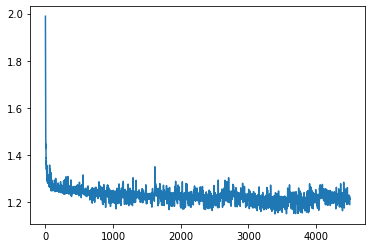

In [29]:
plt.plot(loss_plot[1:])

In [43]:
def test_plot():
    net.eval()
    res = []
    for i, (x,y) in enumerate(testloader):
        optimizer.zero_grad()
        x = x.cuda(async=True)
        y = y.cuda(async=True)
        x = net(x)
        
        x = torch.sigmoid(x).squeeze()
        y = y.squeeze().int().long().cpu().detach().numpy()
        
        x = torch.where(x > 0.5, torch.tensor(1).cuda(), torch.tensor(0).cuda()).cpu().detach().numpy()
        
        acc = np.sum(np.where(x == y,1,0)) / np.sum(np.where(x == x,1,0))
        res.append(acc)
        im = cv2.merge([x*255,y*255,y*255])
        plt.imsave(os.path.join(image_path,(str(i)+'_'+'%4f'%acc+'.png')),im.astype('uint8'), format="png")
        
    return res

In [45]:
resume = os.path.join(weights_path,
                         'net_%s_%s_%s_%f.pth'%(dataset,loss_fuc,net_name,best_acc))
pre_params = torch.load(resume)
net.load_state_dict(pre_params)
res = test_plot()

In [53]:
res = np.array(res)
print(np.mean(res[0:20])) # DRIVE
print(np.mean(res[20:30])) # STARE
print(np.mean(res[30:44])) # CHASEDB1
print(np.mean(res[44:68])) # HRF

0.9670842013888888
0.9737951388888888
0.9749584573412698
0.9682054759837962


In [40]:
test()

ACC: 0.970046
TPR: 0.77560943
FPR: 0.013365276
SN: 0.98663455
SP: 0.77560943


array(0.970046, dtype=float32)